<a href="https://colab.research.google.com/github/rjsdn2308/deep-learning-practice/blob/main/250611_gan_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 19장 세상에 없는 얼굴 GAN, 오토인코더

## 적대적 신경망 실행하기

### 실습: GAN 모델 만들기

In [1]:
import os
if not os.path.exists("./data/gan_images"):
   os.makedirs("./data/gan_images")

In [2]:
!ls -al /content/

total 20
drwxr-xr-x 1 root root 4096 Jun 11 00:38 .
drwxr-xr-x 1 root root 4096 Jun 11 00:37 ..
drwxr-xr-x 4 root root 4096 Jun  9 13:36 .config
drwxr-xr-x 3 root root 4096 Jun 11 00:38 data
drwxr-xr-x 1 root root 4096 Jun  9 13:37 sample_data


In [3]:
!ls -al /content/data

total 12
drwxr-xr-x 3 root root 4096 Jun 11 00:38 .
drwxr-xr-x 1 root root 4096 Jun 11 00:38 ..
drwxr-xr-x 2 root root 4096 Jun 11 00:38 gan_images


In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

import numpy as np
import matplotlib.pyplot as plt

In [5]:
INPUT_DIM = 100

# 생성자 모델 정의
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=INPUT_DIM, activation=LeakyReLU(0.2), kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))  # 입력 벡터를 128*7*7 차원의 벡터로 변환 (잠재 공간 → 특성 맵)
generator.add(BatchNormalization()) # 학습 안정성을 위한 배치 정규화
generator.add(Reshape((7, 7, 128))) # 1D 벡터를 3D 텐서 (7x7x128)로 reshape
generator.add(UpSampling2D()) # 해상도 증가 (7x7 → 14x14)
generator.add(Conv2D(64, kernel_size=5, padding='same'))  # 채널 수를 줄이며 특징 맵 생성
generator.add(BatchNormalization()) # 다시 배치 정규화
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh')) # 최종 출력 이미지 생성 (채널 1개, tanh 활성화로 -1~1 범위)

# 판별자 모델 정의
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

# 생성자와 판별자 모델을 연결시키는 gan 모델 정의
ginput = Input(shape=(INPUT_DIM,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 28, 28, 1)      │       865,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │       212,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,078,146 (4.11 MB)

 Trainable params: 852,609 (3.25 MB)

 Non-trainable params: 225,537 (881.00 KB)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
epoch: 0, d_loss:0.6932, g_loss: 0.6938
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
epoch: 1, d_loss:0.6924, g_loss: 0.6937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
epoch: 2, d_loss:0.6925, g_loss: 0.6936
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
epoch: 3, d_loss:0.6927, g_loss: 0.6939
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
epoch: 4, d_loss:0.6930, g_loss: 0.6940
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
epoch: 5, d_loss:0.6932, g_loss: 0.6940
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
epoch: 6, d_loss:0.6931, g_loss: 0.6941
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
epoch: 7, d_loss:0.6931, g_loss: 0.6941
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
epoch: 8, d_loss:0.6934, g_loss: 0.6941
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
epoch: 9, d_loss:0.6939, g_loss: 0.6942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
epoch: 10, d_loss:0.6943, g_loss: 0.6943
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
epoch: 11, d_loss:0.6941, g_loss: 0.6943
1/1 ━━━━━━━━━━━━━━━━━━

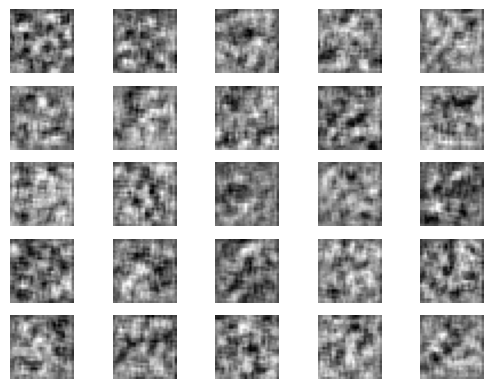

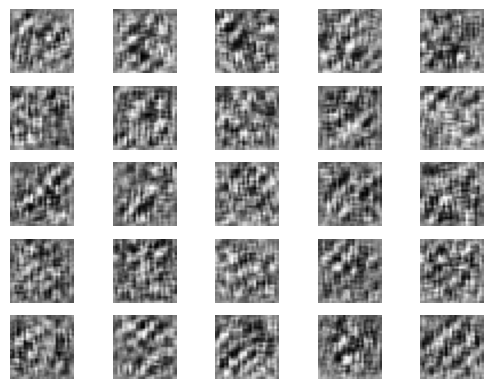

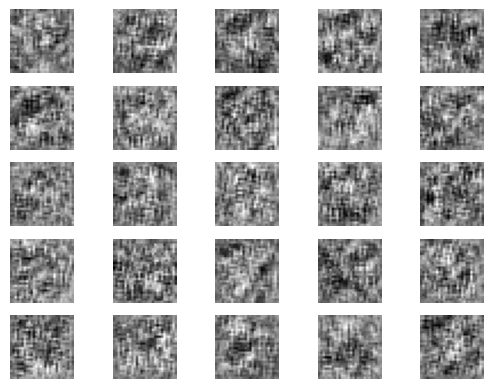

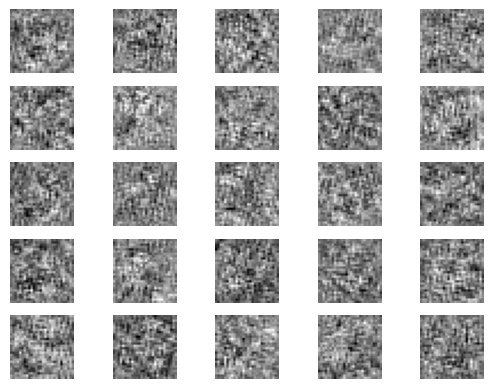

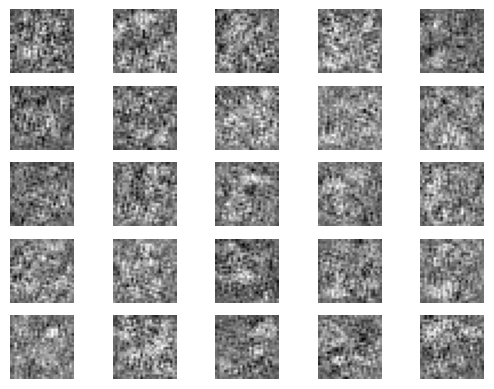

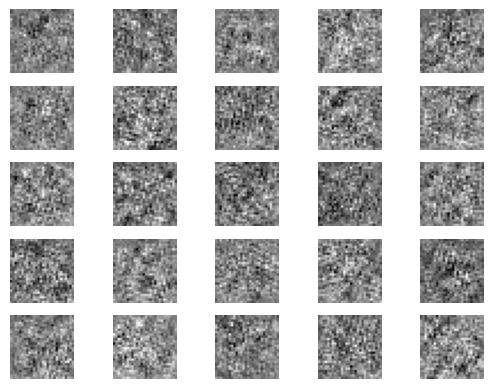

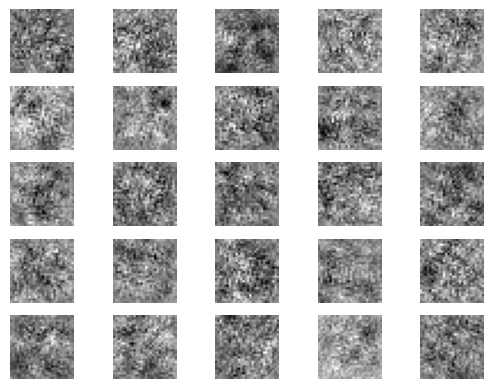

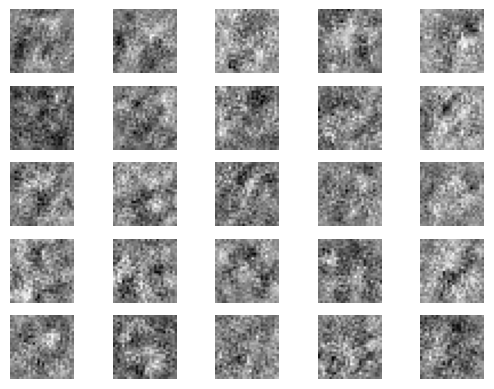

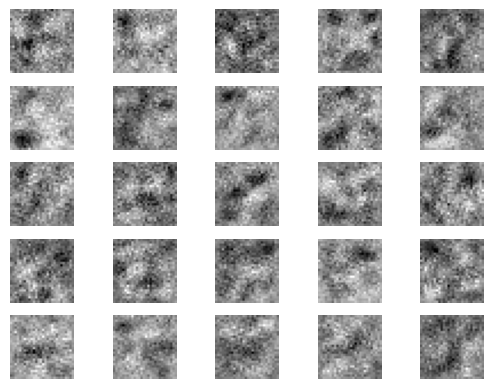

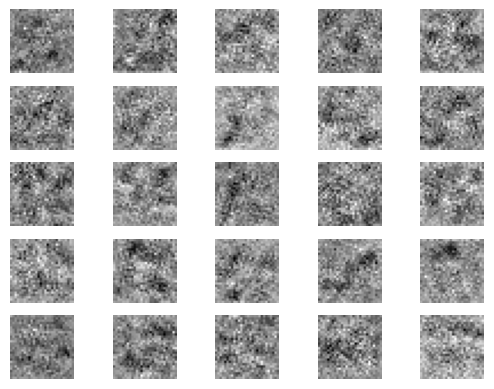

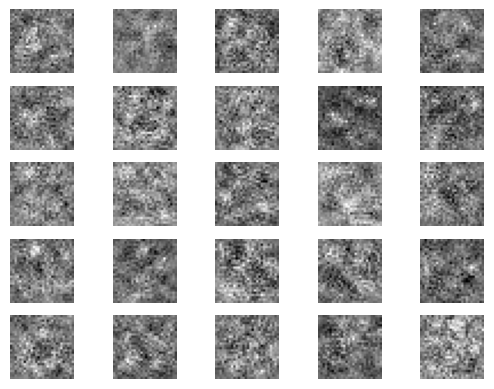

In [6]:
# 신경망 실행 함수 정의
def gan_train(epoch, batch_size, saving_interval):

  (X_train, _), (_, _) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 0 ~ 255 -> -1 ~ 1

  true = np.ones((batch_size, 1)) * 0.5
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력
          noise = np.random.normal(0, 1, (batch_size, INPUT_DIM))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차 계산
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print(f'epoch: {i:d}, d_loss:{d_loss:.4f}, g_loss: {g_loss:.4f}')

          # 생성 이미지 gan_images 폴더에 저장
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, INPUT_DIM))
              gen_imgs = generator.predict(noise)

              # rescale images 0~1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./data/gan_images/gan_mnist_%d.png" % i)

gan_train(2001, 16, 200)

확인문제 : 생성 결과를 확인 후 해당 문제를 개선할 수 있는 방법을 한 가지 적어보세요

## 이미지의 특징을 추출하는 오토인코더

### 실습: 오토인코더 실습하기

In [7]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

In [8]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델 정의
autoencoder = Sequential()

# 인코더 정의
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코더 정의
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

autoencoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 컴파일 및 학습
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.3227 - val_loss: 0.1376
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1317 - val_loss: 0.1157
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1140 - val_loss: 0.1064
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1065 - val_loss: 0.1019
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1022 - val_loss: 0.0993
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0999 - val_loss: 0.0974
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0982 - val_loss: 0.0958
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0971 - val_loss: 0.0945
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0950 - val_loss: 0.0939
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0942 - val_loss: 0.0924
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0933 - val_loss: 0.0915
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/ste

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


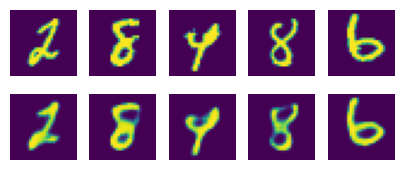

In [10]:
# 학습 결과 예측
random_test = np.random.randint(X_test.shape[0], size=5)
ae_imgs = autoencoder.predict(X_test)

plt.figure(figsize=(7, 2))

for i, image_idx in enumerate(random_test):
   ax = plt.subplot(2, 7, i + 1)
   plt.imshow(X_test[image_idx].reshape(28, 28))
   ax.axis('off')

   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))
   ax.axis('off')

plt.show()